In [12]:
import sklearn.kernel_ridge
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import utils.misc
import pickle
import os
from tqdm import tqdm

In [2]:
plt.rcParams["font.family"] = "Times New Roman"

In [3]:
# Adjust the paths to the validation set and the results derived with the --val flag
val_dataset = h5py.File(os.path.join("/path", "to", "folder", "tggm_val.hdf5"), "r")
results = h5py.File(os.path.join("/path", "to", "folder", "predictions_val.hdf5"), "r")

In [4]:
def shannon_entropy(x, eps=1e-6, C=2):
    x = np.clip(x, eps, 1 - eps)
    return -np.sum(x * np.log(x) / np.log(C), axis=-1)


def shannon_confidence(x):
    return 1 - shannon_entropy(x)

In [5]:
import joblib


def predict_batch(model, batch):
    return model.predict(batch)


def calibrate_confidence(conf, calibration_model, n_jobs=-1, batch_size=2024):
    height, width = conf.shape
    _conf = np.reshape(conf, (height * width, 1))
    batched = [_conf[i: i+batch_size] for i in range(0, len(_conf), batch_size)]
    # conf = calibration_model.predict(conf)
    calibrated_conf = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(predict_batch)(calibration_model, batch) for batch in batched
    )
    calibrated_conf = np.concatenate(calibrated_conf)
    calibrated_conf[calibrated_conf < 0] = 0
    calibrated_conf[calibrated_conf > 1] = 1
    calibrated_conf = np.reshape(calibrated_conf, (height, width))
    return calibrated_conf

In [8]:
def visualise_val_tiles(conf_estimator=shannon_confidence, calibration_model=None, suffix=""):
    tiles_to_visualise = ["ALP-28-23", "HMA-110-76", "SA-95-18", "SC2-59-84"]

    nrows, ncols = 4, len(tiles_to_visualise)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5*ncols, 3.6*nrows))

    for col, tile in enumerate(tiles_to_visualise):
        padding_height = val_dataset[tile].attrs["padding_height"]
        padding_width = val_dataset[tile].attrs["padding_width"]
        
        rgb = np.array(val_dataset[tile]["optical"])[:, :, [2, 1, 0]]
        rgb = utils.misc.norm_to_vis(rgb) + 0.15
        rgb = rgb[padding_height:-padding_height, padding_width:-padding_width, :]
        
        axes[0][col].set_title(tile)
        axes[0][col].imshow(rgb, vmin=0., vmax=0.2, aspect="auto")
        
        groundtruth = np.array(val_dataset[tile]["outlines"])[:, :, -1]
        groundtruth = groundtruth[padding_height:-padding_height, padding_width:-padding_width]
        axes[1][col].imshow(groundtruth, cmap="gray", interpolation="none", aspect="auto")
        
        output_colors = ["black", "white", "red", "green"]
        output_cmap = mpl.colors.ListedColormap(output_colors, 4)
        
        probs = np.array(results[tile]["prob"]).astype(np.double)
        predicted = (probs[..., -1] > 0.5)
        output = np.zeros(predicted.shape)
        output[(predicted == 1) & (groundtruth == 1)] = 1
        output[(predicted == 0) & (groundtruth == 1)] = 2
        output[(predicted == 1) & (groundtruth == 0)] = 3
        axes[2][col].imshow(output / 3, cmap=output_cmap, interpolation="none", aspect="auto", vmin=0, vmax=1)
        
        conf = conf_estimator(probs)
        if calibration_model:
            conf = calibrate_confidence(conf, calibration_model)
        neg = axes[3][col].imshow(conf, aspect="auto", vmin=0, vmax=1)
        
        conf_band = np.zeros((*conf.shape, 4))
        conf_band[:, :, 0] = 1
        conf_band[:, :, 3] = (conf < 0.95) * 0.5
        axes[3][col].imshow(conf_band, aspect="auto", vmin=0, vmax=1)

    for row in range(nrows):
        for col in range(ncols):
            axes[row][col].axis("off")

    plt.tight_layout()
    plt.savefig(os.path.join("figures", f"tiles_val_uncertainty{suffix}.pdf"))
    plt.show()
    plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


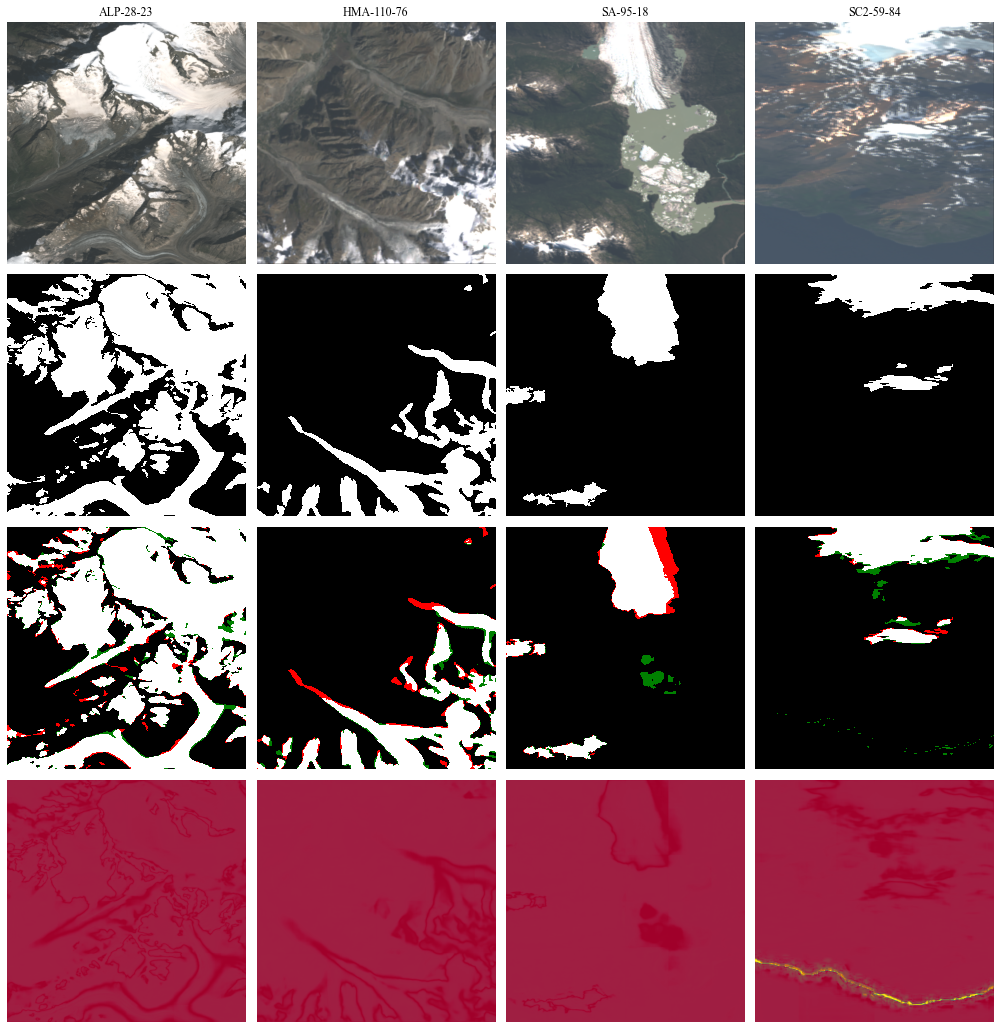

In [9]:
# Adjust the suffix as needed to save the figure
visualise_val_tiles(suffix="_global_softmax")

In [10]:
def get_reliability_diagram(n_bins=10, conf_estimator=shannon_confidence, 
                            calibration_model=None, n_ece_bins=None, suffix=""):
    if n_ece_bins is None:
        n_ece_bins = n_bins
    bins = [(i * 1 / n_bins, (i + 1) * 1 / n_bins) for i in range(n_bins)]
    ece_bins = [(i * 1 / n_ece_bins, (i + 1) * 1 / n_ece_bins) for i in range(n_ece_bins)]
    accuracies = [0 for _ in bins]
    ece_accuracies = [0 for _ in ece_bins]
    confs = [0 for _ in bins]
    ece_confs = [0 for _ in ece_bins]
    counts = [0 for _ in bins]
    ece_counts = [0 for _ in ece_bins]
    
    for group in tqdm(results.keys()):
        padding_height = val_dataset[group].attrs["padding_height"]
        padding_width = val_dataset[group].attrs["padding_width"]
        
        groundtruth = val_dataset[group]["outlines"][:, :, -1]
        groundtruth = groundtruth[padding_height:-padding_height, padding_width:-padding_width]
        
        probs = np.array(results[group]["prob"]).astype(np.double)
        prediction = (probs[..., -1] > 0.5)

        tp = (prediction == 1) & (groundtruth == 1)
        tn = (prediction == 0) & (groundtruth == 0)

        conf = conf_estimator(probs)
        if calibration_model:
            conf = calibrate_confidence(conf, calibration_model)

        for bin_idx, (l, r) in enumerate(bins):
            mask = (conf >= l) & (conf < r)
            counts[bin_idx] += np.sum(mask)
            confs[bin_idx] += np.sum(conf[mask])
            accuracies[bin_idx] += (np.sum(tp[mask]) + np.sum(tn[mask]))
        
        for bin_idx, (l, r) in enumerate(ece_bins):
            mask = (conf >= l) & (conf < r)
            ece_counts[bin_idx] += np.sum(mask)
            ece_confs[bin_idx] += np.sum(conf[mask])
            ece_accuracies[bin_idx] += (np.sum(tp[mask]) + np.sum(tn[mask]))
            
    confs = [conf / count for conf, count in zip(confs, counts)]
    ece_confs = [conf / count for conf, count in zip(ece_confs, ece_counts)]
    accuracies = [acc / count for acc, count in zip(accuracies, counts)]
    ece_accuracies = [acc / count for acc, count in zip(ece_accuracies, ece_counts)]
    
    ece = [count * np.abs(conf - acc) for count, conf, acc in zip(ece_counts, ece_confs, ece_accuracies)]
    ece = np.nansum(ece) / np.nansum(ece_counts)
    
    bins_ = [_[0] for _ in bins] + [1]
    
    _, ax = plt.subplots(figsize=(5, 5))
    ax.hist(bins_[:-1], bins_, weights=accuracies, color="gray", edgecolor="lightgray")
    ax.plot([0, 1], [0, 1], linestyle="dashed", color="lightgreen", alpha=0.95)
    ax.plot(confs, accuracies, marker="x", color="orange")
    ax.text(1.0, 0.015, f"ECE$_{{{n_ece_bins}}}$ = {ece:.5f}", ha="right", va="bottom", fontsize=16, backgroundcolor="white")
    ax.set_xlabel("Confidence", fontsize=16)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([1 / n_bins * _ for _ in range(n_bins + 1)])
    ax.set_ylabel("Accuracy", fontsize=16)
    ax.set_yticks([1 / n_bins * _ for _ in range(n_bins + 1)])
    ax.tick_params(labelsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(("outward", 4))
    ax.spines['bottom'].set_position(("outward", 4))
    #plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join("figures", f"reliability{suffix}.pdf"))
    plt.show()
    plt.close()
    
    return bins, confs, accuracies, counts, ece

100%|███████████████████████████████████████████████████████████████| 547/547 [05:35<00:00,  1.63it/s]


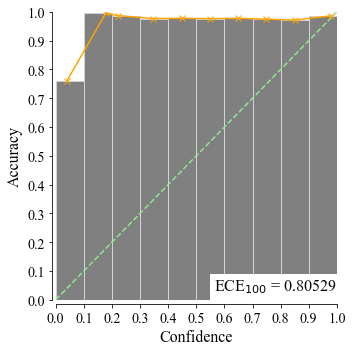

In [11]:
# Adjust the suffix as needed to save the figure
_ = get_reliability_diagram(n_bins=10, n_ece_bins=100, suffix="_global_softmax")

100%|███████████████████████████████████████████████████████████████| 547/547 [04:32<00:00,  2.01it/s]


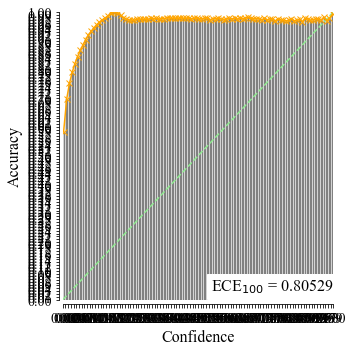

In [13]:
bins, confs, accuracies, counts, _ = get_reliability_diagram(n_bins=100, suffix="tmp")

In [14]:
# in case of a very underconfident model there will be nan values,
# so we filter them out
nan_mask = (np.isnan(confs) | np.isnan(accuracies))
_confs = np.array(confs)[~nan_mask]
_accuracies = np.array(accuracies)[~nan_mask]
_counts = np.array(counts)[~nan_mask]

xs = np.array(_confs)
ys = np.array(_accuracies)

In [16]:
weight_param = 0.1
weights_scale = 1e-2
weights = (_counts / np.max(_counts)) ** weight_param
kernel = "laplacian"

total_xs = np.array([0, *xs, 1])[:, np.newaxis]
total_ys = np.array([0, *ys, 1])
total_weights = np.array([1, *weights, 1])
    
calibration_model = sklearn.kernel_ridge.KernelRidge(alpha=(1 - total_weights) * weights_scale, kernel=kernel)
calibration_model.fit(total_xs, total_ys)

KernelRidge(alpha=array([0.        , 0.00265184, 0.00322597, 0.00337317, 0.00344786,
       0.0034974 , 0.00352953, 0.00353469, 0.00353028, 0.00351085,
       0.00347921, 0.00344124, 0.00339427, 0.00329387, 0.003229  ,
       0.00307666, 0.00284542, 0.00247941, 0.00150547, 0.        ,
       0.00338687, 0.00492291, 0.00550838, 0.00582624, 0.00599569,
       0.00605945, 0.00608092, 0.00611437, 0.00613617, 0.00615186,
       0.00615761, 0.0...
       0.00650139, 0.00651441, 0.00652208, 0.00652886, 0.00654095,
       0.00653951, 0.00654067, 0.00654366, 0.00655944, 0.00654737,
       0.00655658, 0.00654582, 0.00655654, 0.00656021, 0.00654435,
       0.00654668, 0.00654087, 0.00653172, 0.00653144, 0.00652412,
       0.0065149 , 0.00649294, 0.00648344, 0.00646041, 0.00643171,
       0.00641309, 0.00637423, 0.00632404, 0.00624413, 0.00611978,
       0.00528529, 0.        ]),
            kernel='laplacian')

100%|███████████████████████████████████████████████████████████████| 547/547 [04:30<00:00,  2.02it/s]


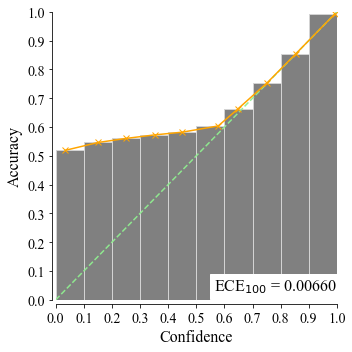

In [17]:
# Adjust the suffix as needed to save the figure
_ = get_reliability_diagram(n_bins=10, n_ece_bins=100, calibration_model=calibration_model, suffix="_global_softmax_calibrated")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


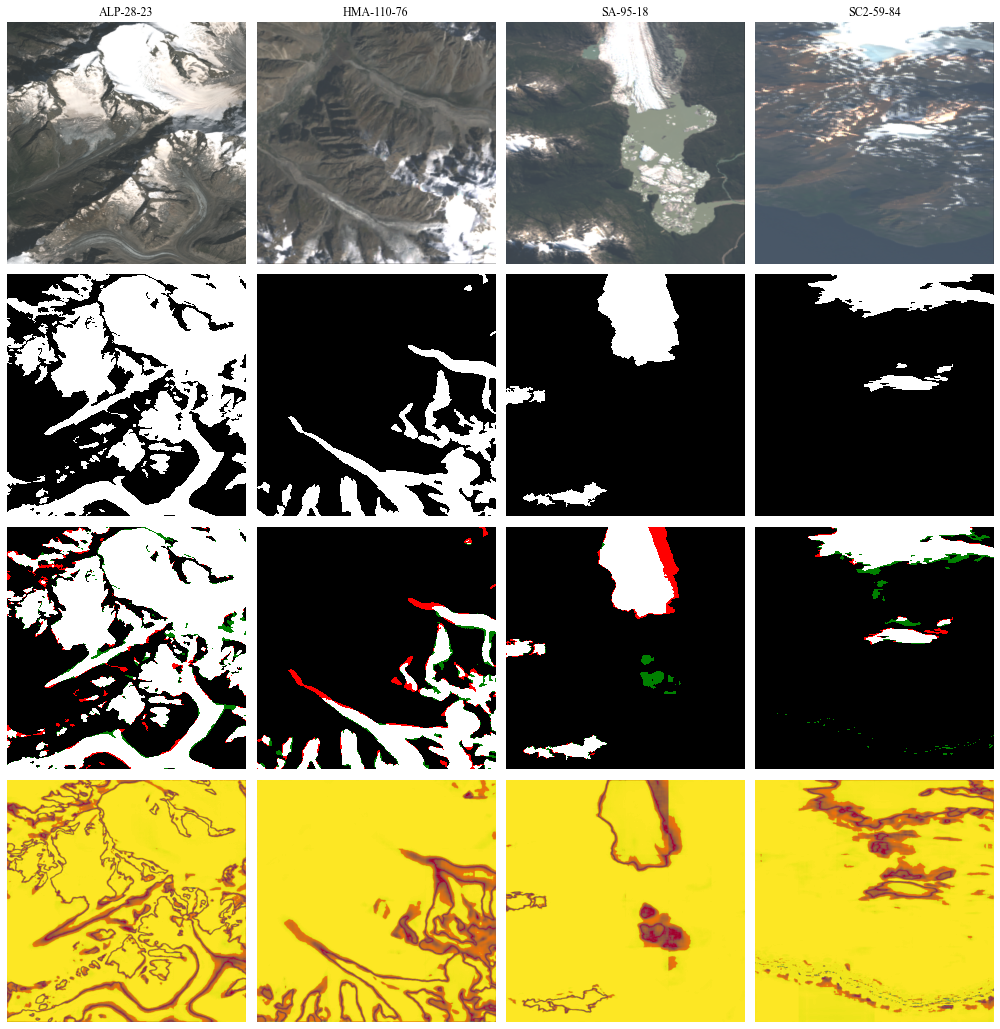

In [18]:
# Adjust the suffix as needed to save the figure
visualise_val_tiles(calibration_model=calibration_model, suffix="_global_softmax_calibrated")

In [19]:
# Adjust the path as needed to save the calibration model
with open(os.path.join("confidence_calibration_models", "confidence_calibration_model.pickle"), "wb") as file:
    pickle.dump(calibration_model, file)